# Koopman kernel models for TC Tracks

[Work in progress]

In [1]:
# %matplotlib inline
from klearn_tcyclone.climada.tc_tracks import TCTracks
import numpy as np
from itertools import product

import matplotlib.pyplot as plt
from klearn_tcyclone.data_utils import context_dataset_from_TCTracks

from sklearn.model_selection import train_test_split
from klearn_tcyclone.data_utils import characteristic_length_scale_from_TCTracks
from kooplearn.models import Kernel, NystroemKernel
from sklearn.gaussian_process.kernels import RBF
from klearn_tcyclone.performance_benchmark import timer
from klearn_tcyclone.data_utils import standardize_TensorContextDataset, LinearScaler

from kooplearn.models import Kernel, NystroemKernel
from klearn_tcyclone.kooplearn.models.nystroem import NystroemKernelCustom

from klearn_tcyclone.performance_benchmark import timer
from klearn_tcyclone.models_utils import predict_time_series

from kooplearn.utils import topk

from klearn_tcyclone.climada.tc_tracks_tools import BASINS

from klearn_tcyclone.utils import check_time_steps_TCTracks
from klearn_tcyclone.kooplearn.spectral_analysis import time_lag_scaling, slide_by_scaling, get_top_k_ev_below_zero, train_model
from klearn_tcyclone.climada.utils import get_TCTrack_dict

from klearn_tcyclone.climada.utils import get_TCTrack_dict
from klearn_tcyclone.kooplearn.spectral_analysis import time_lag_scaling

### Analyse input to models for time_lag.

In [2]:
BASINS

['EP', 'NA', 'NI', 'SI', 'SP', 'WP', 'SA']

In [3]:
time_step_h = 1
basin = "EP"

In [ ]:
tc_tracks = TCTracks.from_ibtracs_netcdf(provider='official', year_range=(2000, 2011), basin=basin)
print('Number of tracks:', tc_tracks.size)
tc_tracks.equal_timestep(time_step_h=time_step_h)
assert check_time_steps_TCTracks(tc_tracks, time_step_h)


2024-11-20 21:01:29,109 - climada.hazard.tc_tracks - WARNING - The cached IBTrACS data set dates from 2023-06-07 23:07:38 (older than 180 days). Very likely, a more recent version is available. Consider manually removing the file C:\Users\Eric\climada\data\IBTrACS.ALL.v04r00.nc and re-running this function, which will download the most recent version of the IBTrACS data set from the official URL.
2024-11-20 21:02:04,684 - climada.hazard.tc_tracks - WARNING - 4 storm events are discarded because no valid wind/pressure values have been found: 2000187N12245, 2000201N11224, 2000203N17249, 2000228N31180.


c:\Users\Eric\Projects\koopman_learning_tropical_cyclone\.venv\Lib\site-packages\climada\hazard\tc_tracks.py:614: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if ibtracs_ds.dims['storm'] == 0:


Number of tracks: 215


In [ ]:
len(tc_tracks.data)

215

In [ ]:
tc_tracks_train, tc_tracks_test = train_test_split(tc_tracks.data, test_size=0.1)
feature_list = ["lon", "lat", "max_sustained_wind"]

In [ ]:
context_length = 12
time_lag = 1

In [ ]:
tensor_context_train = context_dataset_from_TCTracks(
    tc_tracks_train, feature_list=feature_list, context_length=context_length, time_lag=time_lag,
)
tensor_context_test = context_dataset_from_TCTracks(
    tc_tracks_test, feature_list=feature_list, context_length=context_length, time_lag=time_lag,
)
contexts = {
    "train": tensor_context_train,
    "test": tensor_context_test,
}
scaler = LinearScaler()
tensor_context_train_transformed = standardize_TensorContextDataset(
    tensor_context_train,
    scaler,
    fit=True,
)
tensor_context_test_transformed = standardize_TensorContextDataset(
    tensor_context_test,
    scaler,
    fit=False,
)

contexts = {
    "train": tensor_context_train_transformed,
    "test": tensor_context_test_transformed,
}

In [ ]:
### Spectral analysis
reduced_rank = False
# reduced_rank = True
rank = 25
num_centers = 300
tikhonov_reg = 1e-8

# Instantiang the RBF kernel and its length scale as the median of the pairwise distances of the dataset
length_scale = 10.0
kernel = RBF(length_scale=length_scale)
nys_rrr = NystroemKernelCustom(kernel=kernel, reduced_rank=reduced_rank, svd_solver='arnoldi', tikhonov_reg=tikhonov_reg, rank = rank, num_centers=num_centers, rng_seed=42)
# nys_rrr = NystroemKernel(kernel=kernel, reduced_rank=reduced_rank, svd_solver='arnoldi', tikhonov_reg=tikhonov_reg, rank = rank, num_centers=num_centers, rng_seed=42)
print(contexts["train"].shape)
nys_rrr = nys_rrr.fit(contexts["train"], slide_by=3)
# nys_rrr = nys_rrr.fit(contexts["train"])


X_pred = nys_rrr.predict(contexts["test"])  # Here we must pass the `X` part of the context
X_true = contexts["test"].lookforward(nys_rrr.lookback_len)# This is the `Y` part of the test context
rmse_onestep = np.sqrt(np.mean((X_pred - X_true)**2))

(26764, 12, 3)


In [ ]:
rmse_onestep

np.float64(2.3065700440597525)

In [ ]:
data = contexts["train"]
data.shape, data.context_length

((26764, 12, 3), 12)

In [ ]:
data.data[0,:,0]

array([-0.49038458, -0.48579591, -0.48094439, -0.47596145, -0.47097851,
       -0.46612702, -0.46153841, -0.45730169, -0.45333628, -0.44951917,
       -0.44571893, -0.44177038])

In [ ]:
data.data[1,:,0]

array([-0.48579591, -0.48094439, -0.47596145, -0.47097851, -0.46612702,
       -0.46153841, -0.45730169, -0.45333628, -0.44951917, -0.44571893,
       -0.44177038, -0.43749994])

In [ ]:
# Save the lookback length
slide_by = 3
lookback_len = data.context_length - slide_by
# lookback_len = data.context_length - 1
X_fit, Y_fit = data.lookback(lookback_len), data.lookback(
    lookback_len, slide_by=slide_by
)


In [ ]:
X_fit.shape, Y_fit.shape

((26764, 9, 3), (26764, 9, 3))

In [ ]:
data.data[0,:,0]

array([-0.49038458, -0.48579591, -0.48094439, -0.47596145, -0.47097851,
       -0.46612702, -0.46153841, -0.45730169, -0.45333628, -0.44951917,
       -0.44571893, -0.44177038])

In [ ]:
[
    (X_fit[idx,:,0], Y_fit[idx,:,0], "")
    for idx in range(10)
]

[(array([-0.49038458, -0.48579591, -0.48094439, -0.47596145, -0.47097851,
         -0.46612702, -0.46153841, -0.45730169, -0.45333628]),
  array([-0.47596145, -0.47097851, -0.46612702, -0.46153841, -0.45730169,
         -0.45333628, -0.44951917, -0.44571893, -0.44177038]),
  ''),
 (array([-0.48579591, -0.48094439, -0.47596145, -0.47097851, -0.46612702,
         -0.46153841, -0.45730169, -0.45333628, -0.44951917]),
  array([-0.47097851, -0.46612702, -0.46153841, -0.45730169, -0.45333628,
         -0.44951917, -0.44571893, -0.44177038, -0.43749994]),
  ''),
 (array([-0.48094439, -0.47596145, -0.47097851, -0.46612702, -0.46153841,
         -0.45730169, -0.45333628, -0.44951917, -0.44571893]),
  array([-0.46612702, -0.46153841, -0.45730169, -0.45333628, -0.44951917,
         -0.44571893, -0.44177038, -0.43749994, -0.43281014]),
  ''),
 (array([-0.47596145, -0.47097851, -0.46612702, -0.46153841, -0.45730169,
         -0.45333628, -0.44951917, -0.44571893, -0.44177038]),
  array([-0.46153841

## Scaling of time scales

We compare spectral signatures for different basins and time frequencies of the tropical cyclones.

In [2]:
print(f"Basins are given by {BASINS}.")

Basins are given by ['EP', 'NA', 'NI', 'SI', 'SP', 'WP', 'SA'].


Load data

In [3]:
# time_step_h = 1.0
time_step_h = 1.0
basins = BASINS[:2]
# basins = BASINS[:-5]
# year_range = (2000, 2010)
year_range = (2000, 2021)
tc_tracks_dict = get_TCTrack_dict(basins,time_step_h, year_range)

c:\Users\Eric\Projects\koopman_learning_tropical_cyclone\.venv\Lib\site-packages\xarray\backends\plugins.py:75: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


2024-11-27 22:10:40,519 - climada.hazard.tc_tracks - WARNING - The cached IBTrACS data set dates from 2023-06-07 23:07:38 (older than 180 days). Very likely, a more recent version is available. Consider manually removing the file C:\Users\Eric\climada\data\IBTrACS.ALL.v04r00.nc and re-running this function, which will download the most recent version of the IBTrACS data set from the official URL.
2024-11-27 22:11:50,584 - climada.hazard.tc_tracks - WARNING - 4 storm events are discarded because no valid wind/pressure values have been found: 2000187N12245, 2000201N11224, 2000203N17249, 2000228N31180.


c:\Users\Eric\Projects\koopman_learning_tropical_cyclone\.venv\Lib\site-packages\climada\hazard\tc_tracks.py:614: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if ibtracs_ds.dims['storm'] == 0:
c:\Users\Eric\Projects\koopman_learning_tropical_cyclone\.venv\Lib\site-packages\climada\hazard\tc_tracks.py:1511: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "_one_interp_data" failed type inference due to: non-precise type pyobject
During: typing of argument at c:\Users\Eric\Projects\koopman_learning_tropical_cyclone\.venv\Lib\site-packages\climada\hazard\tc_tracks.py (1545)

File "..\.venv\Lib\site-packages\climada\hazard\tc_tracks.py", line 1545:
    def _one_interp_data(track, time_step_h, land_geom=None):
        <source elided>

   

2024-11-27 22:12:09,826 - climada.hazard.tc_tracks - WARNING - The cached IBTrACS data set dates from 2023-06-07 23:07:38 (older than 180 days). Very likely, a more recent version is available. Consider manually removing the file C:\Users\Eric\climada\data\IBTrACS.ALL.v04r00.nc and re-running this function, which will download the most recent version of the IBTrACS data set from the official URL.


c:\Users\Eric\Projects\koopman_learning_tropical_cyclone\.venv\Lib\site-packages\climada\hazard\tc_tracks.py:614: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if ibtracs_ds.dims['storm'] == 0:


In [4]:
model_config = {
    "length_scale": 10.0,
    "reduced_rank": False,
    "rank": 50,
    "num_centers": 2400,
    "tikhonov_reg": 1e-8,
    "svd_solver": "arnoldi",
    "rng_seed": 42,
}

# context_length = 2
# context_length = 8
# context_length = 16
context_length = 64
top_k = 10
feature_list = ['lon', 'lat', 'max_sustained_wind', 'radius_max_wind', 'radius_oci', 'central_pressure', 'environmental_pressure']

Note: Context length 16 seems to be quite a bit better than context length 8, however we can only go to time lage of 15 with this, for time_step_h = 1.

In [5]:
time_step_scaling = int(3 / time_step_h)
time_step_scaling

3

### Time lag scaling

In [19]:
time_lags = np.array(range(1, 11, 1)) * time_step_scaling
time_lags = [1,2,4] + list(np.array(range(1, 6, 1)) * time_step_scaling)

time_lags = [50]
# time_lags = range(1, 25, 2)
# time_lags = range(0, 60, 5)
# time_lags = range(1, 10, 2)
# time_lags = [1, 5, 10]
time_lags

[50]

In [20]:
evals_d = {}
error_d = {}
tscale_d = {}
for basin in basins:
    ev_d, e_d, ts_d = time_lag_scaling(tc_tracks_dict[basin], time_lags=time_lags, context_length=context_length, top_k=top_k, model_config=model_config, feature_list=feature_list)
    evals_d[basin] = ev_d
    error_d[basin] = e_d
    tscale_d[basin] = ts_d


Train with time_lag 50.
Data entry 0 has been removed since it is shorter than the 
                    context_length 64 times time_lag 50.
Data entry 1 has been removed since it is shorter than the 
                    context_length 64 times time_lag 50.
Data entry 2 has been removed since it is shorter than the 
                    context_length 64 times time_lag 50.
Data entry 3 has been removed since it is shorter than the 
                    context_length 64 times time_lag 50.
Data entry 4 has been removed since it is shorter than the 
                    context_length 64 times time_lag 50.
Data entry 5 has been removed since it is shorter than the 
                    context_length 64 times time_lag 50.
Data entry 6 has been removed since it is shorter than the 
                    context_length 64 times time_lag 50.
Data entry 7 has been removed since it is shorter than the 
                    context_length 64 times time_lag 50.
Data entry 8 has been removed since it i

In [21]:
evals_d, error_d, tscale_d

({'EP': {50: None}, 'NA': {50: None}},
 {'EP': {50: None}, 'NA': {50: None}},
 {'EP': {50: array([None, None, None, None, None, None, None, None, None, None],
         dtype=object)},
  'NA': {50: array([None, None, None, None, None, None, None, None, None, None],
         dtype=object)}})

RMSE error as a function of the time-lag. The basin is given in the legend.

Context length 16

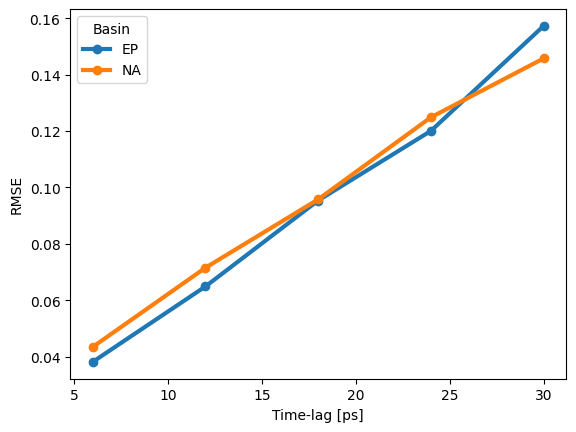

In [9]:
fig, ax = plt.subplots()
# fig.set_size_inches(16, 8)

for basin in basins:
    ax.plot(error_d[basin].keys(), error_d[basin].values(), lw=3, marker='o', label=basin)
ax.set_xlabel("Time-lag [ps]")
ax.set_ylabel("RMSE")
# ax.margins(x=0)
ax.legend(title="Basin")

Context length 8

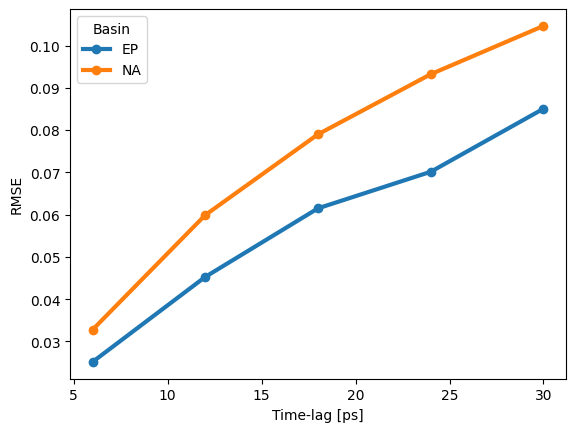

In [23]:
fig, ax = plt.subplots()
# fig.set_size_inches(16, 8)

for basin in basins:
    ax.plot(error_d[basin].keys(), error_d[basin].values(), lw=3, marker='o', label=basin)
ax.set_xlabel("Time-lag [ps]")
ax.set_ylabel("RMSE")
# ax.margins(x=0)
ax.legend(title="Basin")

Context length 2

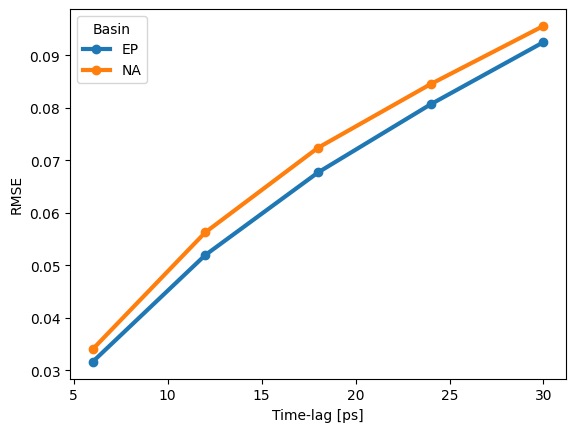

In [33]:
fig, ax = plt.subplots()
# fig.set_size_inches(16, 8)

for basin in basins:
    ax.plot(error_d[basin].keys(), error_d[basin].values(), lw=3, marker='o', label=basin)
ax.set_xlabel("Time-lag [ps]")
ax.set_ylabel("RMSE")
# ax.margins(x=0)
ax.legend(title="Basin")

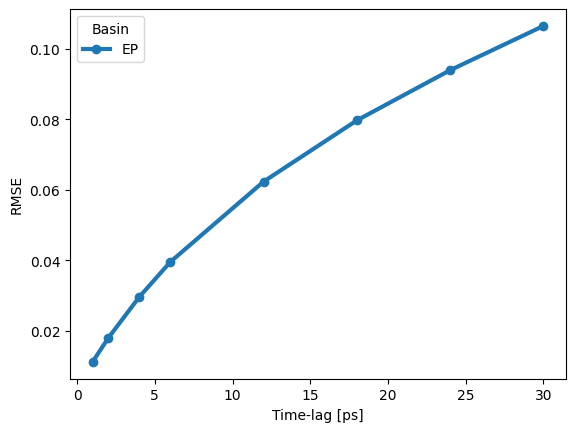

In [41]:
fig, ax = plt.subplots()
# fig.set_size_inches(16, 8)

for basin in basins[:1]:
    ax.plot(error_d[basin].keys(), error_d[basin].values(), lw=3, marker='o', label=basin)
ax.set_xlabel("Time-lag [ps]")
ax.set_ylabel("RMSE")
# ax.margins(x=0)
ax.legend(title="Basin")

In [42]:
from itertools import product

In [43]:
top_k

10

Context length 16

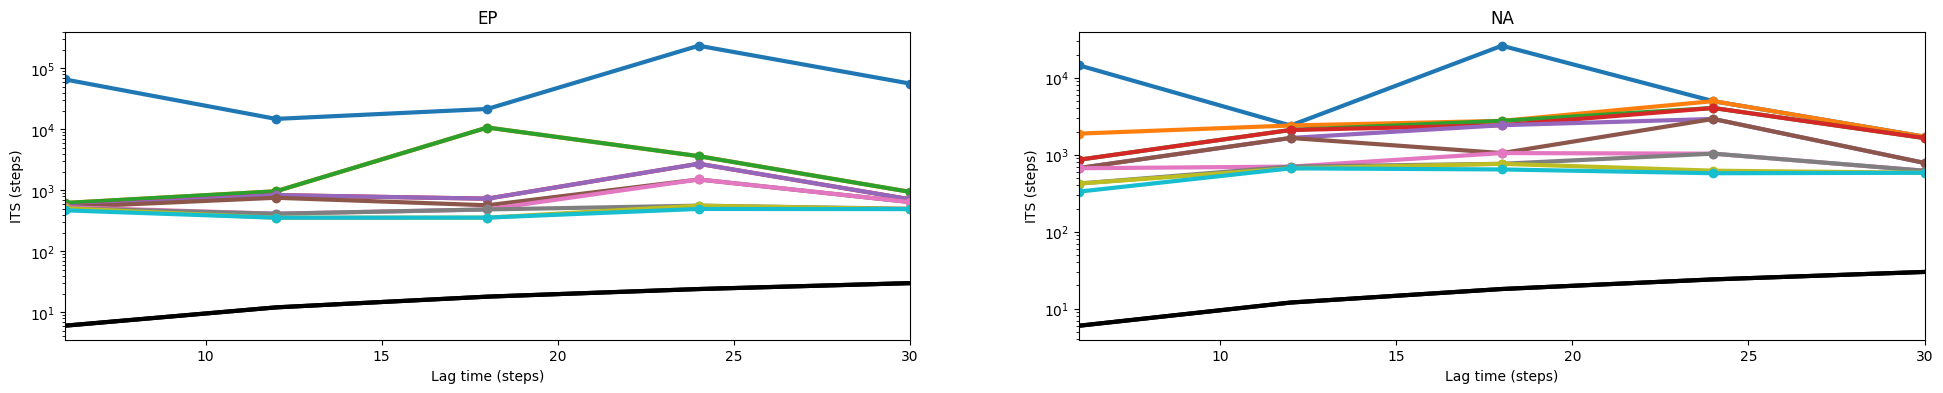

In [18]:
fig, ax = plt.subplots(ncols=len(basins), figsize=(9, 4.5))
fig.set_size_inches(24, 4)

basin = basins[1]
start_idx = 0

for idx, basin in enumerate(basins):

    for idx_k in range(0, top_k):
        try:
            ax[idx].plot(time_lags[start_idx:], [tscale[idx_k] for tscale in tscale_d[basin].values()][start_idx:], lw=3, marker='o')
        except:
            print(idx, idx_k)
    # ax[idx].plot(time_lags[start_idx:], [tscale[1] for tscale in tscale_d[basin].values()][start_idx:], lw=3, marker='o')
    # ax[idx].plot(time_lags[start_idx:], [tscale[2] for tscale in tscale_d[basin].values()][start_idx:], lw=3, marker='o')
    # ax[idx].plot(time_lags[start_idx:], [tscale[3] for tscale in tscale_d[basin].values()][start_idx:], lw=3, marker='o')
    # ax[idx].plot(time_lags[start_idx:], [tscale[4] for tscale in tscale_d[basin].values()][start_idx:], lw=3, marker='o')

    ax[idx].plot(time_lags[start_idx:], time_lags[start_idx:], lw=3, c='k')
    ax[idx].plot(time_lags[start_idx:], time_lags[start_idx:], lw=3, c='k')

    ax[idx].set_xlabel("Lag time (steps)")
    ax[idx].set_ylabel("ITS (steps)")
    ax[idx].set_title(basin)
    ax[idx].margins(x=0)
    # ax[idx].set_xscale("log")
    ax[idx].set_yscale("log")

Context length 8

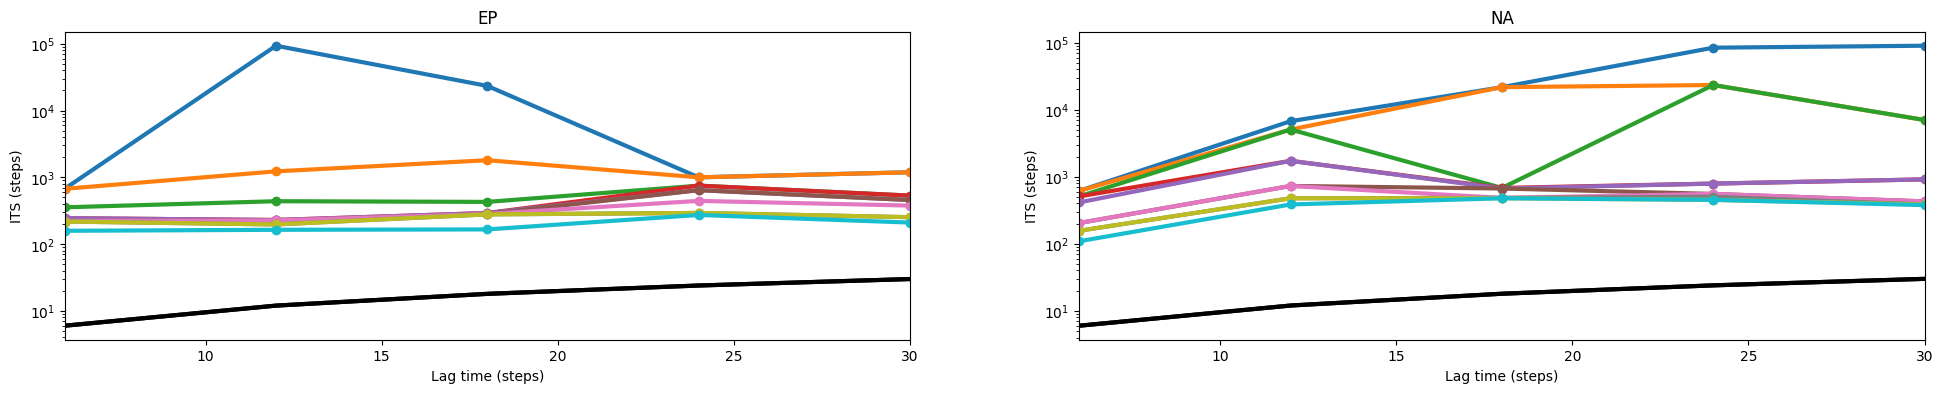

In [26]:
fig, ax = plt.subplots(ncols=len(basins), figsize=(9, 4.5))
fig.set_size_inches(24, 4)

basin = basins[1]
start_idx = 0

for idx, basin in enumerate(basins):

    for idx_k in range(0, top_k):
        try:
            ax[idx].plot(time_lags[start_idx:], [tscale[idx_k] for tscale in tscale_d[basin].values()][start_idx:], lw=3, marker='o')
        except:
            print(idx, idx_k)
    # ax[idx].plot(time_lags[start_idx:], [tscale[1] for tscale in tscale_d[basin].values()][start_idx:], lw=3, marker='o')
    # ax[idx].plot(time_lags[start_idx:], [tscale[2] for tscale in tscale_d[basin].values()][start_idx:], lw=3, marker='o')
    # ax[idx].plot(time_lags[start_idx:], [tscale[3] for tscale in tscale_d[basin].values()][start_idx:], lw=3, marker='o')
    # ax[idx].plot(time_lags[start_idx:], [tscale[4] for tscale in tscale_d[basin].values()][start_idx:], lw=3, marker='o')

    ax[idx].plot(time_lags[start_idx:], time_lags[start_idx:], lw=3, c='k')
    ax[idx].plot(time_lags[start_idx:], time_lags[start_idx:], lw=3, c='k')

    ax[idx].set_xlabel("Lag time (steps)")
    ax[idx].set_ylabel("ITS (steps)")
    ax[idx].set_title(basin)
    ax[idx].margins(x=0)
    # ax[idx].set_xscale("log")
    ax[idx].set_yscale("log")

Context length 2

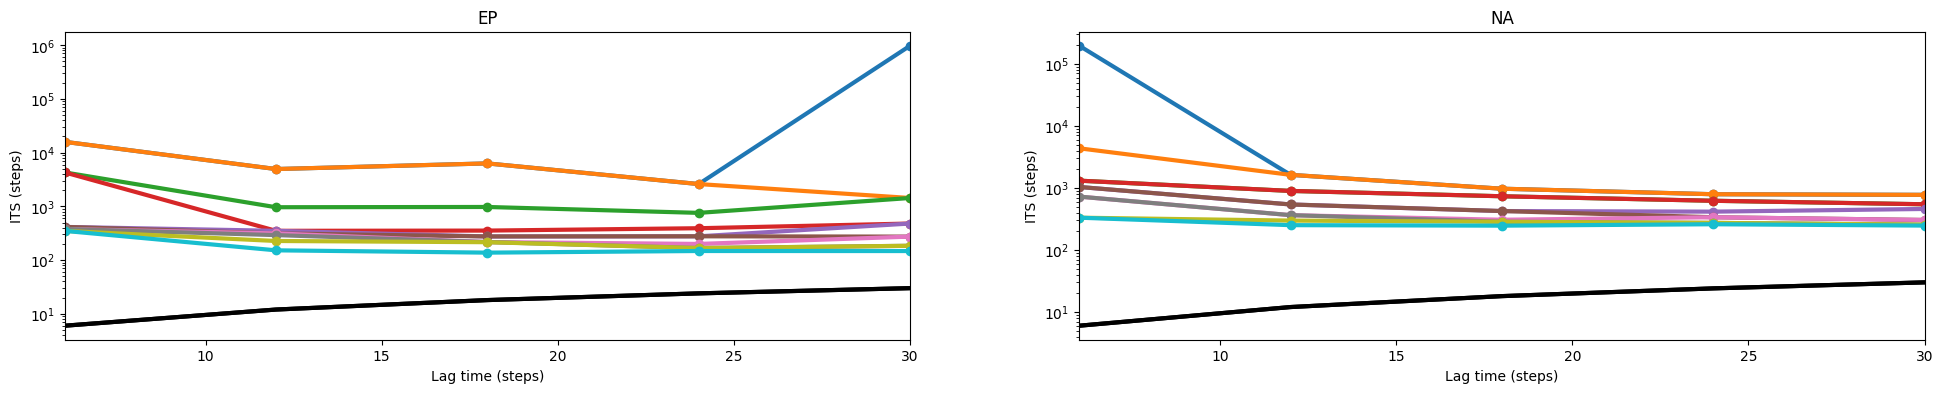

In [35]:
fig, ax = plt.subplots(ncols=len(basins), figsize=(9, 4.5))
fig.set_size_inches(24, 4)

basin = basins[1]
start_idx = 0

for idx, basin in enumerate(basins):

    for idx_k in range(0, top_k):
        try:
            ax[idx].plot(time_lags[start_idx:], [tscale[idx_k] for tscale in tscale_d[basin].values()][start_idx:], lw=3, marker='o')
        except:
            print(idx, idx_k)
    # ax[idx].plot(time_lags[start_idx:], [tscale[1] for tscale in tscale_d[basin].values()][start_idx:], lw=3, marker='o')
    # ax[idx].plot(time_lags[start_idx:], [tscale[2] for tscale in tscale_d[basin].values()][start_idx:], lw=3, marker='o')
    # ax[idx].plot(time_lags[start_idx:], [tscale[3] for tscale in tscale_d[basin].values()][start_idx:], lw=3, marker='o')
    # ax[idx].plot(time_lags[start_idx:], [tscale[4] for tscale in tscale_d[basin].values()][start_idx:], lw=3, marker='o')

    ax[idx].plot(time_lags[start_idx:], time_lags[start_idx:], lw=3, c='k')
    ax[idx].plot(time_lags[start_idx:], time_lags[start_idx:], lw=3, c='k')

    ax[idx].set_xlabel("Lag time (steps)")
    ax[idx].set_ylabel("ITS (steps)")
    ax[idx].set_title(basin)
    ax[idx].margins(x=0)
    # ax[idx].set_xscale("log")
    ax[idx].set_yscale("log")

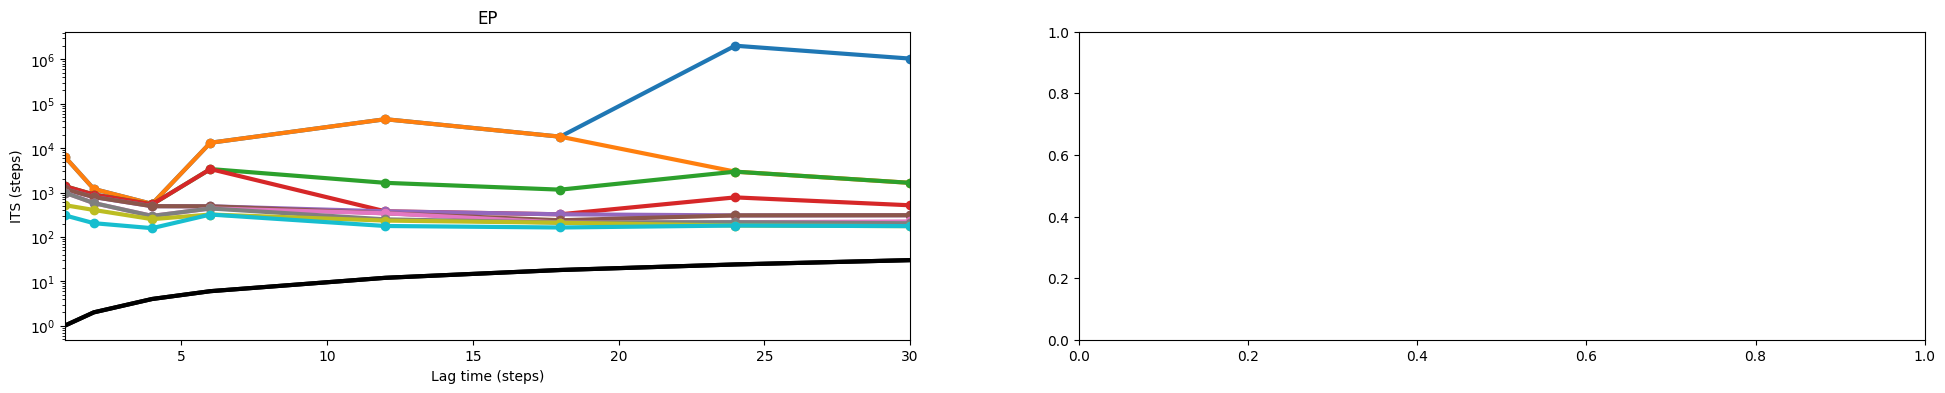

In [44]:
fig, ax = plt.subplots(ncols=len(basins), figsize=(9, 4.5))
fig.set_size_inches(24, 4)

basin = basins[1]
start_idx = 0

for idx, basin in enumerate(basins[:1]):

    for idx_k in range(0, top_k):
        try:
            ax[idx].plot(time_lags[start_idx:], [tscale[idx_k] for tscale in tscale_d[basin].values()][start_idx:], lw=3, marker='o')
        except:
            print(idx, idx_k)
    # ax[idx].plot(time_lags[start_idx:], [tscale[1] for tscale in tscale_d[basin].values()][start_idx:], lw=3, marker='o')
    # ax[idx].plot(time_lags[start_idx:], [tscale[2] for tscale in tscale_d[basin].values()][start_idx:], lw=3, marker='o')
    # ax[idx].plot(time_lags[start_idx:], [tscale[3] for tscale in tscale_d[basin].values()][start_idx:], lw=3, marker='o')
    # ax[idx].plot(time_lags[start_idx:], [tscale[4] for tscale in tscale_d[basin].values()][start_idx:], lw=3, marker='o')

    ax[idx].plot(time_lags[start_idx:], time_lags[start_idx:], lw=3, c='k')
    ax[idx].plot(time_lags[start_idx:], time_lags[start_idx:], lw=3, c='k')

    ax[idx].set_xlabel("Lag time (steps)")
    ax[idx].set_ylabel("ITS (steps)")
    ax[idx].set_title(basin)
    ax[idx].margins(x=0)
    # ax[idx].set_xscale("log")
    ax[idx].set_yscale("log")

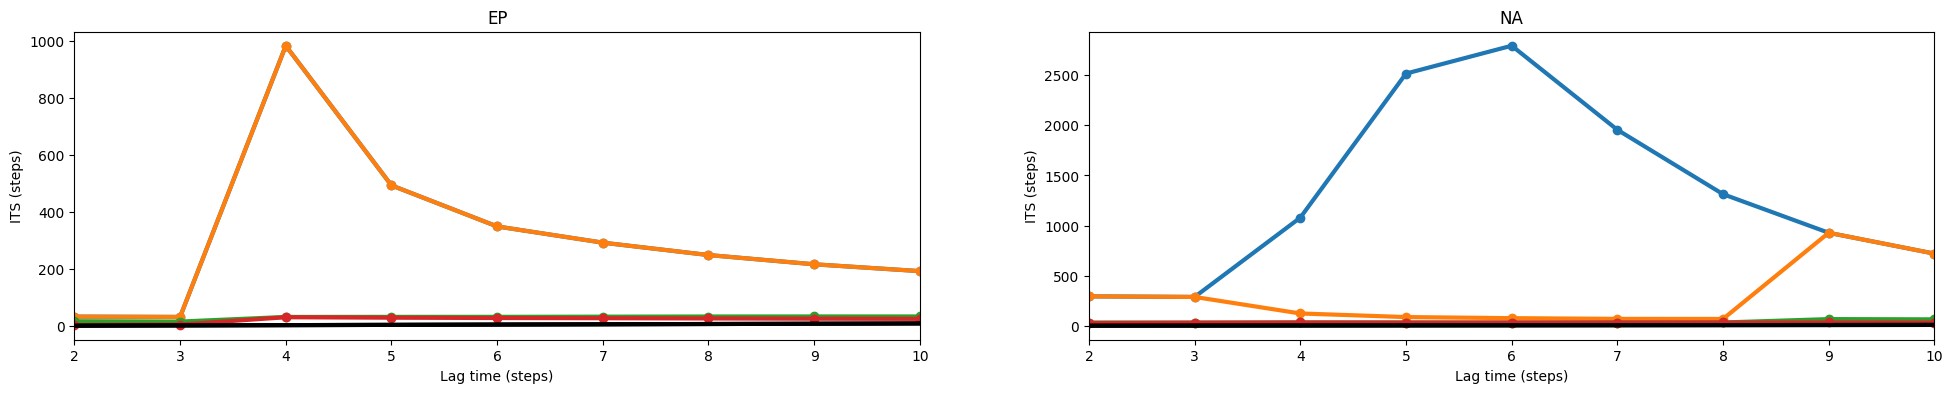

In [46]:
fig, ax = plt.subplots(ncols=len(basins), figsize=(9, 4.5))
fig.set_size_inches(24, 4)

basin = basins[1]
start_idx = 1

for idx, basin in enumerate(basins):

    for idx_k in range(1, top_k):
        ax[idx].plot(time_lags[start_idx:], [tscale[idx_k] for tscale in tscale_d[basin].values()][start_idx:], lw=3, marker='o')
    # ax[idx].plot(time_lags[start_idx:], [tscale[1] for tscale in tscale_d[basin].values()][start_idx:], lw=3, marker='o')
    # ax[idx].plot(time_lags[start_idx:], [tscale[2] for tscale in tscale_d[basin].values()][start_idx:], lw=3, marker='o')
    # ax[idx].plot(time_lags[start_idx:], [tscale[3] for tscale in tscale_d[basin].values()][start_idx:], lw=3, marker='o')
    # ax[idx].plot(time_lags[start_idx:], [tscale[4] for tscale in tscale_d[basin].values()][start_idx:], lw=3, marker='o')

    ax[idx].plot(time_lags[start_idx:], time_lags[start_idx:], lw=3, c='k')
    ax[idx].plot(time_lags[start_idx:], time_lags[start_idx:], lw=3, c='k')

    ax[idx].set_xlabel("Lag time (steps)")
    ax[idx].set_ylabel("ITS (steps)")
    ax[idx].set_title(basin)
    ax[idx].margins(x=0)
    # ax[idx].set_xscale("log")
    # ax[idx].set_yscale("log")

### Old plots

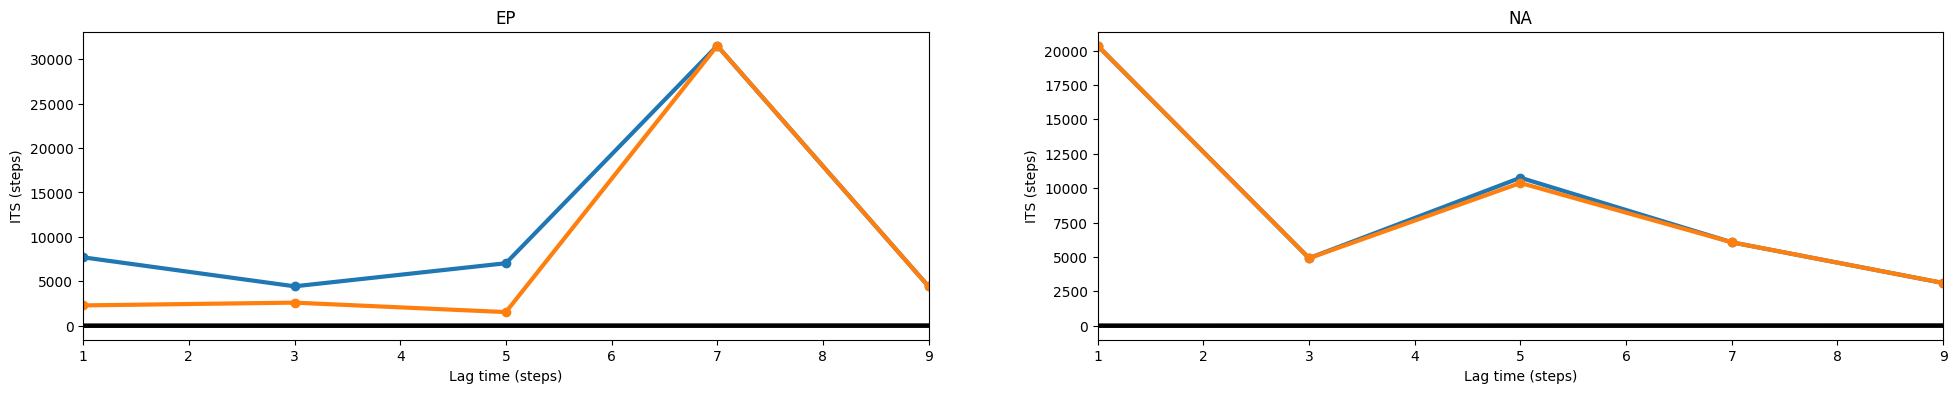

In [247]:
fig, ax = plt.subplots(ncols=len(basins), figsize=(9, 4.5))
fig.set_size_inches(24, 4)

basin = basins[1]
start_idx = 0

for idx, basin in enumerate(basins):

    # ax[idx].plot(time_lags[start_idx:], [tscale[0] for tscale in tscale_d[basin].values()][start_idx:], lw=3, marker='o')
    ax[idx].plot(time_lags[start_idx:], [tscale[1] for tscale in tscale_d[basin].values()][start_idx:], lw=3, marker='o')
    ax[idx].plot(time_lags[start_idx:], [tscale[2] for tscale in tscale_d[basin].values()][start_idx:], lw=3, marker='o')
    # ax[idx].plot(time_lags[start_idx:], [tscale[3] for tscale in tscale_d[basin].values()], lw=3, marker='o')

    ax[idx].plot(time_lags[start_idx:], time_lags[start_idx:], lw=3, c='k')
    ax[idx].plot(time_lags[start_idx:], time_lags[start_idx:], lw=3, c='k')

    ax[idx].set_xlabel("Lag time (steps)")
    ax[idx].set_ylabel("ITS (steps)")
    ax[idx].set_title(basin)
    ax[idx].margins(x=0)
    # ax[idx].set_xscale("log")
    # ax[idx].set_yscale("log")

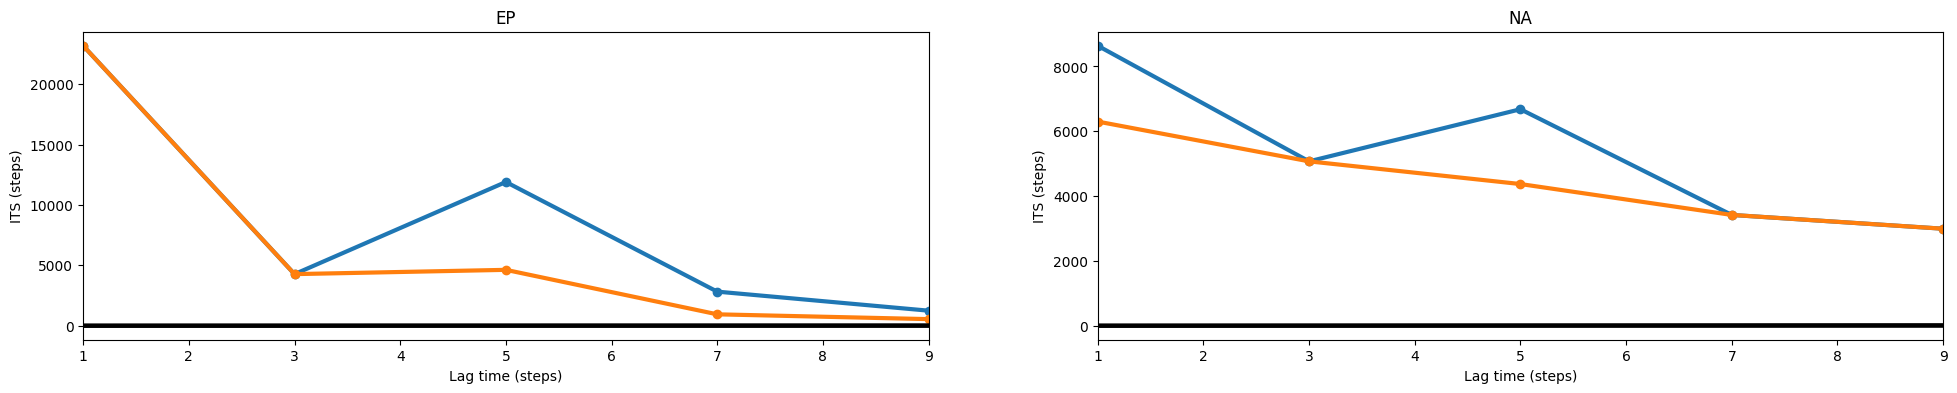

In [198]:
fig, ax = plt.subplots(ncols=len(basins), figsize=(9, 4.5))
fig.set_size_inches(24, 4)

basin = basins[1]

for idx, basin in enumerate(basins):

    # ax[idx].plot(time_lags, [tscale[0] for tscale in tscale_d[basin].values()], lw=3, marker='o')
    ax[idx].plot(time_lags, [tscale[1] for tscale in tscale_d[basin].values()], lw=3, marker='o')
    ax[idx].plot(time_lags, [tscale[2] for tscale in tscale_d[basin].values()], lw=3, marker='o')
    # ax[idx].plot(time_lags, [tscale[3] for tscale in tscale_d[basin].values()], lw=3, marker='o')

    ax[idx].plot(time_lags, time_lags, lw=3, c='k')
    ax[idx].plot(time_lags, time_lags, lw=3, c='k')

    ax[idx].set_xlabel("Lag time (steps)")
    ax[idx].set_ylabel("ITS (steps)")
    ax[idx].set_title(basin)
    ax[idx].margins(x=0)
    # ax[idx].set_xscale("log")
    # ax[idx].set_yscale("log")

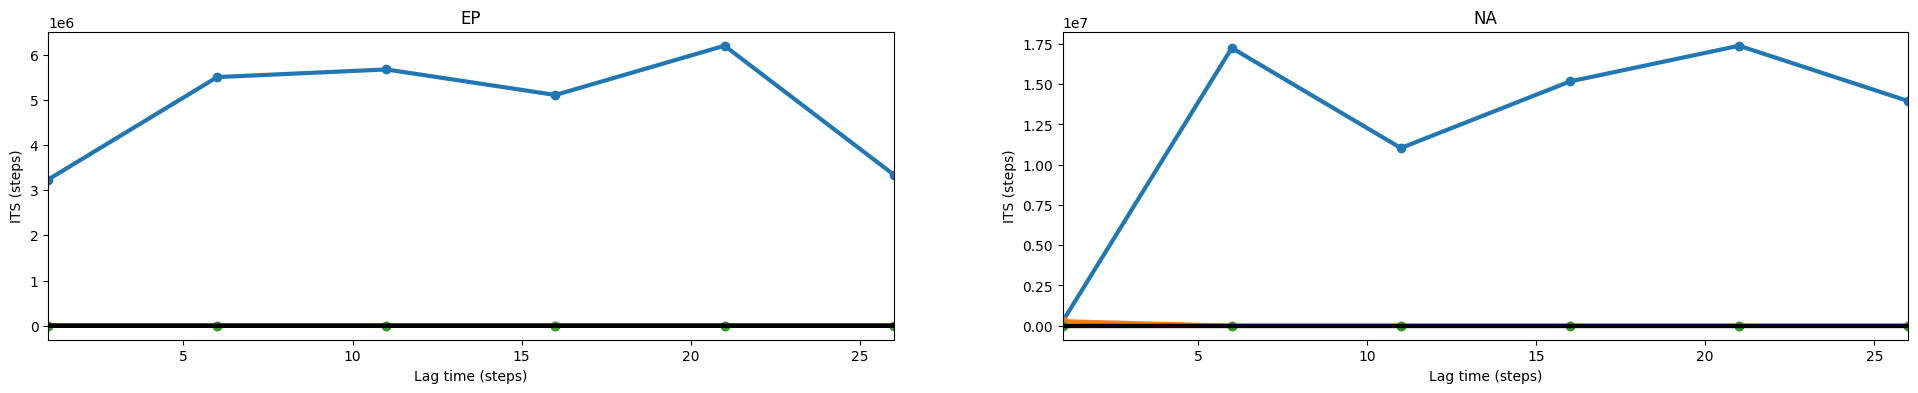

In [54]:
fig, ax = plt.subplots(ncols=len(basins), figsize=(9, 4.5))
fig.set_size_inches(24, 4)

basin = basins[1]

for idx, basin in enumerate(basins):

    ax[idx].plot(time_lags, [tscale[0] for tscale in tscale_d[basin].values()], lw=3, marker='o')
    ax[idx].plot(time_lags, [tscale[1] for tscale in tscale_d[basin].values()], lw=3, marker='o')
    ax[idx].plot(time_lags, [tscale[2] for tscale in tscale_d[basin].values()], lw=3, marker='o')
    # ax[idx].plot(time_lags, [tscale[3] for tscale in tscale_d[basin].values()], lw=3, marker='o')

    ax[idx].plot(time_lags, time_lags, lw=3, c='k')
    ax[idx].plot(time_lags, time_lags, lw=3, c='k')

    ax[idx].set_xlabel("Lag time (steps)")
    ax[idx].set_ylabel("ITS (steps)")
    ax[idx].set_title(basin)
    ax[idx].margins(x=0)
    # ax[idx].set_xscale("log")
    # ax[idx].set_yscale("log")

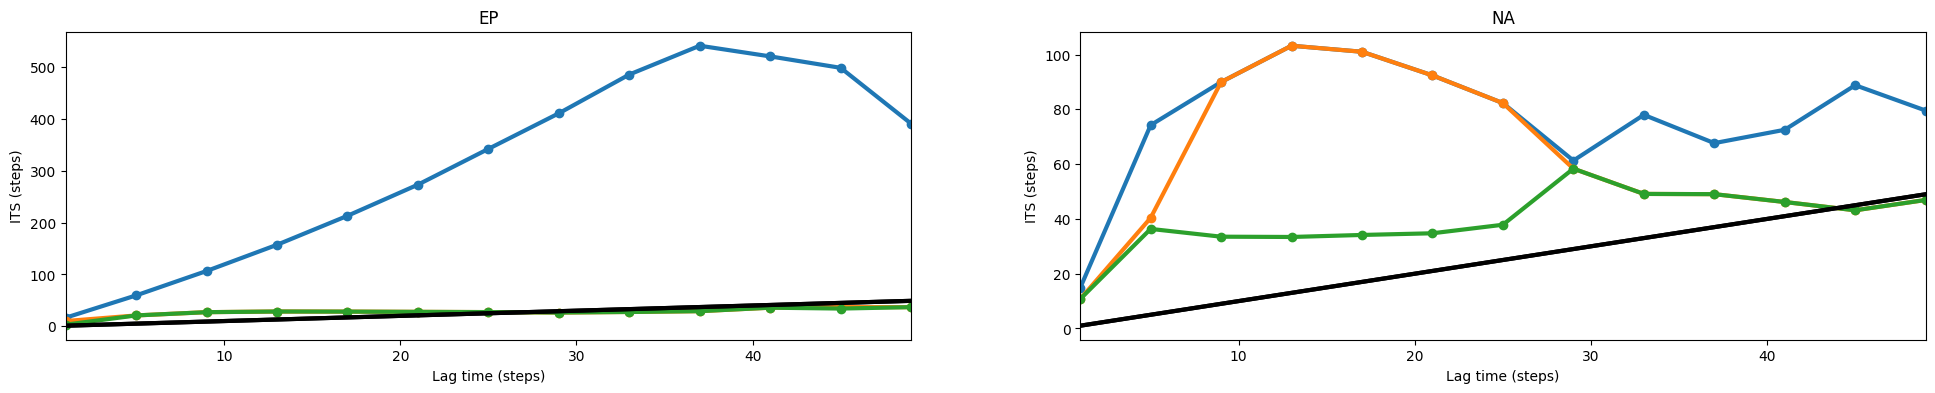

In [24]:
fig, ax = plt.subplots(ncols=len(basins), figsize=(9, 4.5))
fig.set_size_inches(24, 4)

basin = basins[1]

for idx, basin in enumerate(basins):

    ax[idx].plot(time_lags, [tscale[1] for tscale in tscale_d[basin].values()], lw=3, marker='o')
    ax[idx].plot(time_lags, [tscale[2] for tscale in tscale_d[basin].values()], lw=3, marker='o')
    ax[idx].plot(time_lags, [tscale[3] for tscale in tscale_d[basin].values()], lw=3, marker='o')

    ax[idx].plot(time_lags, time_lags, lw=3, c='k')
    ax[idx].plot(time_lags, time_lags, lw=3, c='k')

    ax[idx].set_xlabel("Lag time (steps)")
    ax[idx].set_ylabel("ITS (steps)")
    ax[idx].set_title(basin)
    ax[idx].margins(x=0)
    # ax[idx].set_xscale("log")
    # ax[idx].set_yscale("log")

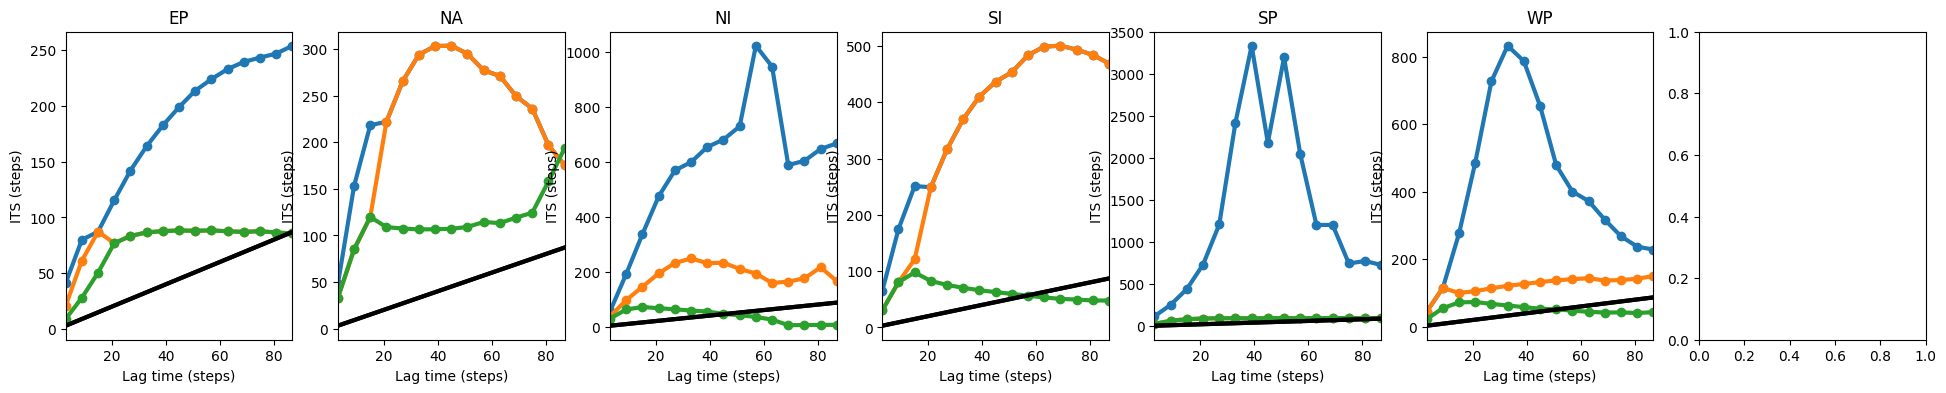

In [112]:
fig, ax = plt.subplots(ncols=len(BASINS), figsize=(9, 4.5))
fig.set_size_inches(24, 4)

basin = BASINS[1]

for idx, basin in enumerate(BASINS[:-1]):

    ax[idx].plot(time_lags, [tscale[1] for tscale in tscale_d[basin].values()], lw=3, marker='o')
    ax[idx].plot(time_lags, [tscale[2] for tscale in tscale_d[basin].values()], lw=3, marker='o')
    ax[idx].plot(time_lags, [tscale[3] for tscale in tscale_d[basin].values()], lw=3, marker='o')

    ax[idx].plot(time_lags, time_lags, lw=3, c='k')
    ax[idx].plot(time_lags, time_lags, lw=3, c='k')

    ax[idx].set_xlabel("Lag time (steps)")
    ax[idx].set_ylabel("ITS (steps)")
    ax[idx].set_title(basin)
    ax[idx].margins(x=0)
    # ax[idx].set_xscale("log")
    # ax[idx].set_yscale("log")

In [ ]:
a = None

In [21]:
len(time_lags)

15

EP
NA
NI
SI
SP
WP


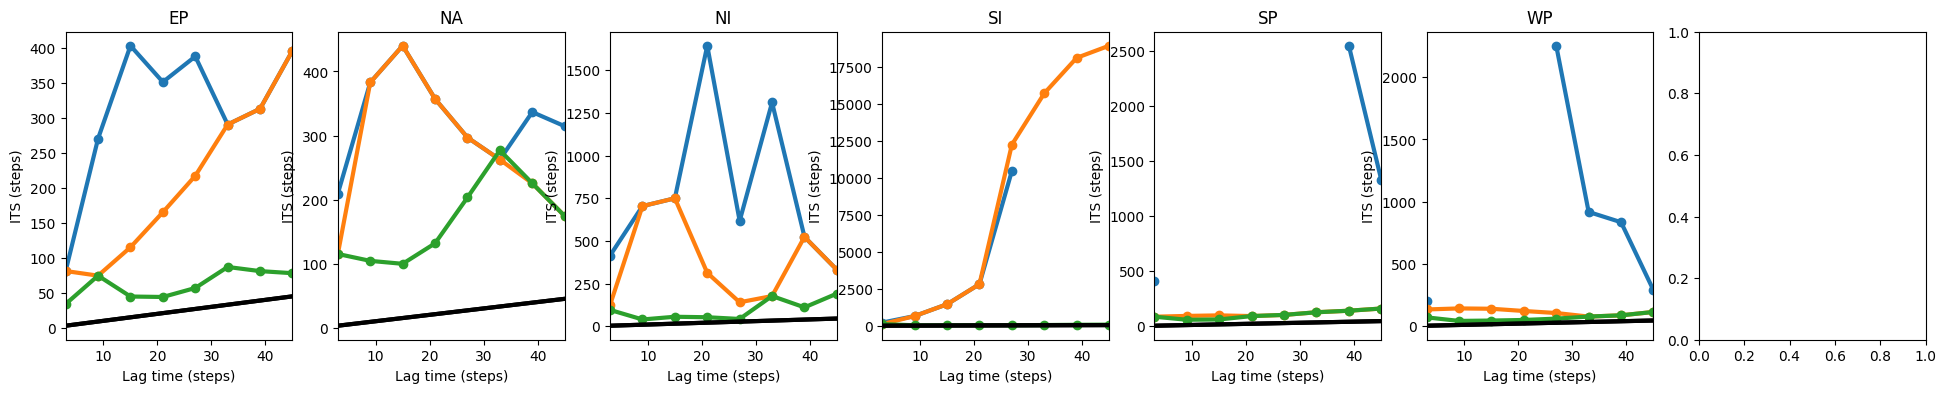

In [26]:
fig, ax = plt.subplots(ncols=len(BASINS), figsize=(9, 4.5))
fig.set_size_inches(24, 4)

basin = BASINS[1]

max_time_lag_idx = 8
for idx, basin in enumerate(BASINS[:-1]):

    print(basin)
    ax[idx].plot(time_lags[:max_time_lag_idx], [tscale[1] for tscale in list(tscale_d[basin].values())[:max_time_lag_idx]], lw=3, marker='o')
    ax[idx].plot(time_lags[:max_time_lag_idx], [tscale[2] for tscale in list(tscale_d[basin].values())[:max_time_lag_idx]], lw=3, marker='o')
    ax[idx].plot(time_lags[:max_time_lag_idx], [tscale[3] for tscale in list(tscale_d[basin].values())[:max_time_lag_idx]], lw=3, marker='o')

    ax[idx].plot(time_lags[:max_time_lag_idx], time_lags[:max_time_lag_idx], lw=3, c='k')
    ax[idx].plot(time_lags[:max_time_lag_idx], time_lags[:max_time_lag_idx], lw=3, c='k')

    ax[idx].set_xlabel("Lag time (steps)")
    ax[idx].set_ylabel("ITS (steps)")
    ax[idx].set_title(basin)
    ax[idx].margins(x=0)
    # ax[idx].set_xscale("log")
    # ax[idx].set_yscale("log")

### Slide-by scaling

In [ ]:
evals_d = {}
error_d = {}
tscale_d = {}

slide_bys = range(1, 6)
# slide_bys = range(1, 10, 2)
# slide_bys = range(1, 30, 5)
# slide_bys = [1, 5, 10]

time_lags = slide_bys
for basin in basins:
    ev_d, e_d, ts_d = slide_by_scaling(tc_tracks_dict[basin], slide_bys=slide_bys, context_length=context_length, top_k=top_k, model_config=model_config, feature_list=feature_list)
    evals_d[basin] = ev_d
    error_d[basin] = e_d
    tscale_d[basin] = ts_d


Train with slide_by 1.
Train with slide_by 2.
Train with slide_by 3.
Train with slide_by 4.
Train with slide_by 5.


RMSE error as a function of the time-lag. The basin is given in the legend.

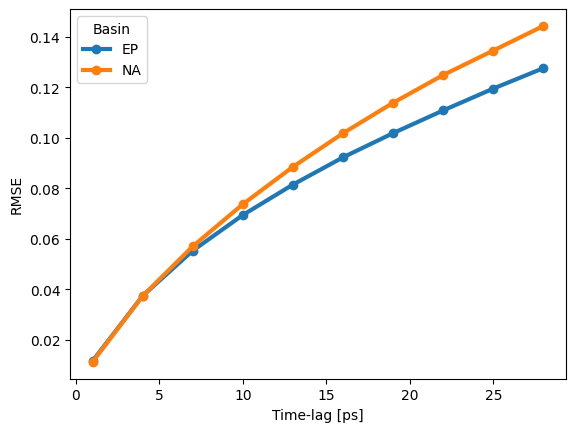

In [ ]:
fig, ax = plt.subplots()
# fig.set_size_inches(16, 8)

for basin in basins:
    ax.plot(error_d[basin].keys(), error_d[basin].values(), lw=3, marker='o', label=basin)
ax.set_xlabel("Time-lag [ps]")
ax.set_ylabel("RMSE")
# ax.margins(x=0)
ax.legend(title="Basin")

In [ ]:
from itertools import product

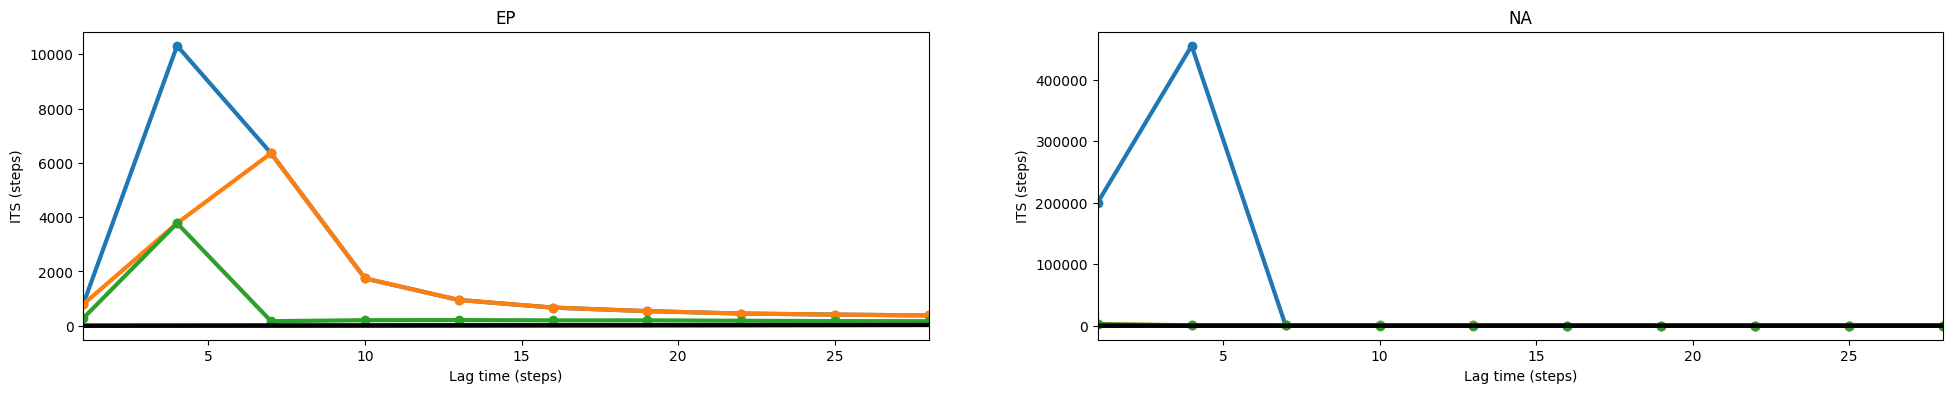

In [ ]:
fig, ax = plt.subplots(ncols=len(basins), figsize=(9, 4.5))
fig.set_size_inches(24, 4)

basin = basins[1]
start_idx = 0

for idx, basin in enumerate(basins):

    ax[idx].plot(time_lags[start_idx:], [tscale[0] for tscale in tscale_d[basin].values()][start_idx:], lw=3, marker='o')
    ax[idx].plot(time_lags[start_idx:], [tscale[1] for tscale in tscale_d[basin].values()][start_idx:], lw=3, marker='o')
    ax[idx].plot(time_lags[start_idx:], [tscale[2] for tscale in tscale_d[basin].values()][start_idx:], lw=3, marker='o')
    # ax[idx].plot(time_lags[start_idx:], [tscale[3] for tscale in tscale_d[basin].values()], lw=3, marker='o')

    ax[idx].plot(time_lags[start_idx:], time_lags[start_idx:], lw=3, c='k')
    ax[idx].plot(time_lags[start_idx:], time_lags[start_idx:], lw=3, c='k')

    ax[idx].set_xlabel("Lag time (steps)")
    ax[idx].set_ylabel("ITS (steps)")
    ax[idx].set_title(basin)
    ax[idx].margins(x=0)
    # ax[idx].set_xscale("log")
    # ax[idx].set_yscale("log")

## Plot eigenfunctions along trajectories

In [5]:
from klearn_tcyclone.kooplearn.spectral_analysis import get_top_k_ev_and_indices_below_zero

<GeoAxes: >

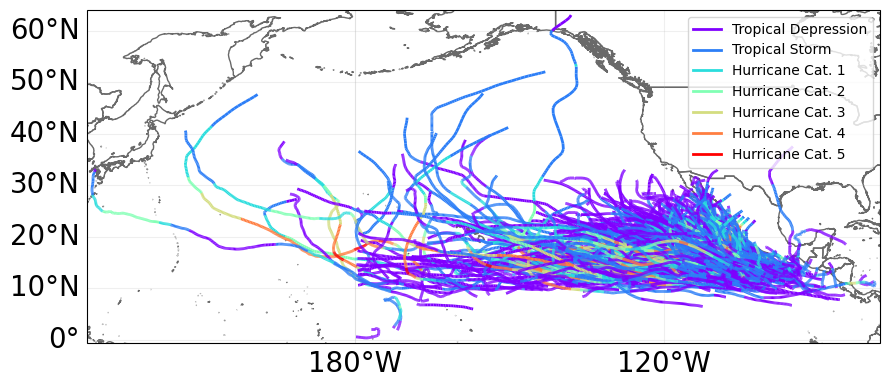

In [91]:
tc_tracks_dict["EP"].plot()

In [6]:
model_config = {
    "length_scale": 10.0,
    "reduced_rank": False,
    "rank": 50,
    "num_centers": 600,
    "tikhonov_reg": 1e-8,
    "svd_solver": "arnoldi",
    "rng_seed": 42,
}

context_length = 2
# context_length = 19
# context_length = 16
top_k = 10
# top_k = 42
# feature_list = ['lon', 'lat', 'max_sustained_wind', 'radius_max_wind', 'radius_oci', 'central_pressure', 'environmental_pressure']
feature_list = ['lon', 'lat', 'max_sustained_wind', 'radius_max_wind', 'radius_oci', 'central_pressure', 'environmental_pressure']

In [7]:
time_lag = 5
slide_by = 1

In [8]:
tc_tracks_dict

{'EP': <klearn_tcyclone.climada.tc_tracks.TCTracks at 0x26783c60190>,
 'NA': <klearn_tcyclone.climada.tc_tracks.TCTracks at 0x267811b3f50>}

In [9]:
basins

['EP', 'NA']

In [ ]:
tc_tracks_train, tc_tracks_test = train_test_split(tc_tracks_dict["EP"].data, test_size=0.1)
tensor_context_train = context_dataset_from_TCTracks(
    tc_tracks_train,
    feature_list=feature_list,
    context_length=context_length,
    time_lag=time_lag,
)
tensor_context_test = context_dataset_from_TCTracks(
    tc_tracks_test,
    feature_list=feature_list,
    context_length=context_length,
    time_lag=time_lag,
)
contexts = {
    "train": tensor_context_train,
    "test": tensor_context_test,
}

scaler = LinearScaler()
tensor_context_train_transformed = standardize_TensorContextDataset(
    tensor_context_train,
    scaler,
    fit=True,
    periodic_shift=True,
    basin="EP",
)
tensor_context_test_transformed = standardize_TensorContextDataset(
    tensor_context_test,
    scaler,
    fit=False,
    periodic_shift=True,
    basin="EP",
)

contexts = {
    "train": tensor_context_train_transformed,
    "test": tensor_context_test_transformed,
}


# Instantiang the RBF kernel and its length scale as the median of the pairwise distances of the dataset
kernel = RBF(length_scale=model_config["length_scale"])
nys_rrr = NystroemKernelCustom(
    kernel=kernel,
    reduced_rank=model_config["reduced_rank"],
    svd_solver=model_config["svd_solver"],
    tikhonov_reg=model_config["tikhonov_reg"],
    rank=model_config["rank"],
    num_centers=model_config["num_centers"],
    rng_seed=model_config["rng_seed"],
)
nys_rrr = nys_rrr.fit(contexts["train"], slide_by=slide_by)

In [14]:
test_dataset = contexts["train"]

In [15]:
evals, evec_right = nys_rrr.eig(eval_right_on=test_dataset)

In [16]:
# evals_k = evals
# evec_right_k = evec_right

indices_k, evals_k = get_top_k_ev_and_indices_below_zero(evals, top_k)
print(evals_k)

# top_evals = topk(np.abs(evals), top_k)
# indices_k = top_evals.indices
# evals_k = evals[indices_k]
# print(evals_k)

evec_right_k = evec_right[:, indices_k]

[0.99994496+0.j         0.98192817+0.j         0.96911716+0.12649109j
 0.96911716-0.12649109j 0.90538753+0.j         0.87867198+0.j
 0.8752071 +0.05371681j 0.8752071 -0.05371681j 0.8382668 +0.j
 0.81473378+0.09672392j]


In [17]:
evec_idx = list(range(top_k))
# evec_idx = list(range(0, 50, 4))

d:\work\projects\repositories\koopman_learning_tropical_cyclone\.venv\Lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
d:\work\projects\repositories\koopman_learning_tropical_cyclone\.venv\Lib\site-packages\matplotlib\axes\_axes.py:4590: ComplexWarning: Casting complex values to real discards the imaginary part
  c = np.asanyarray(c, dtype=float)


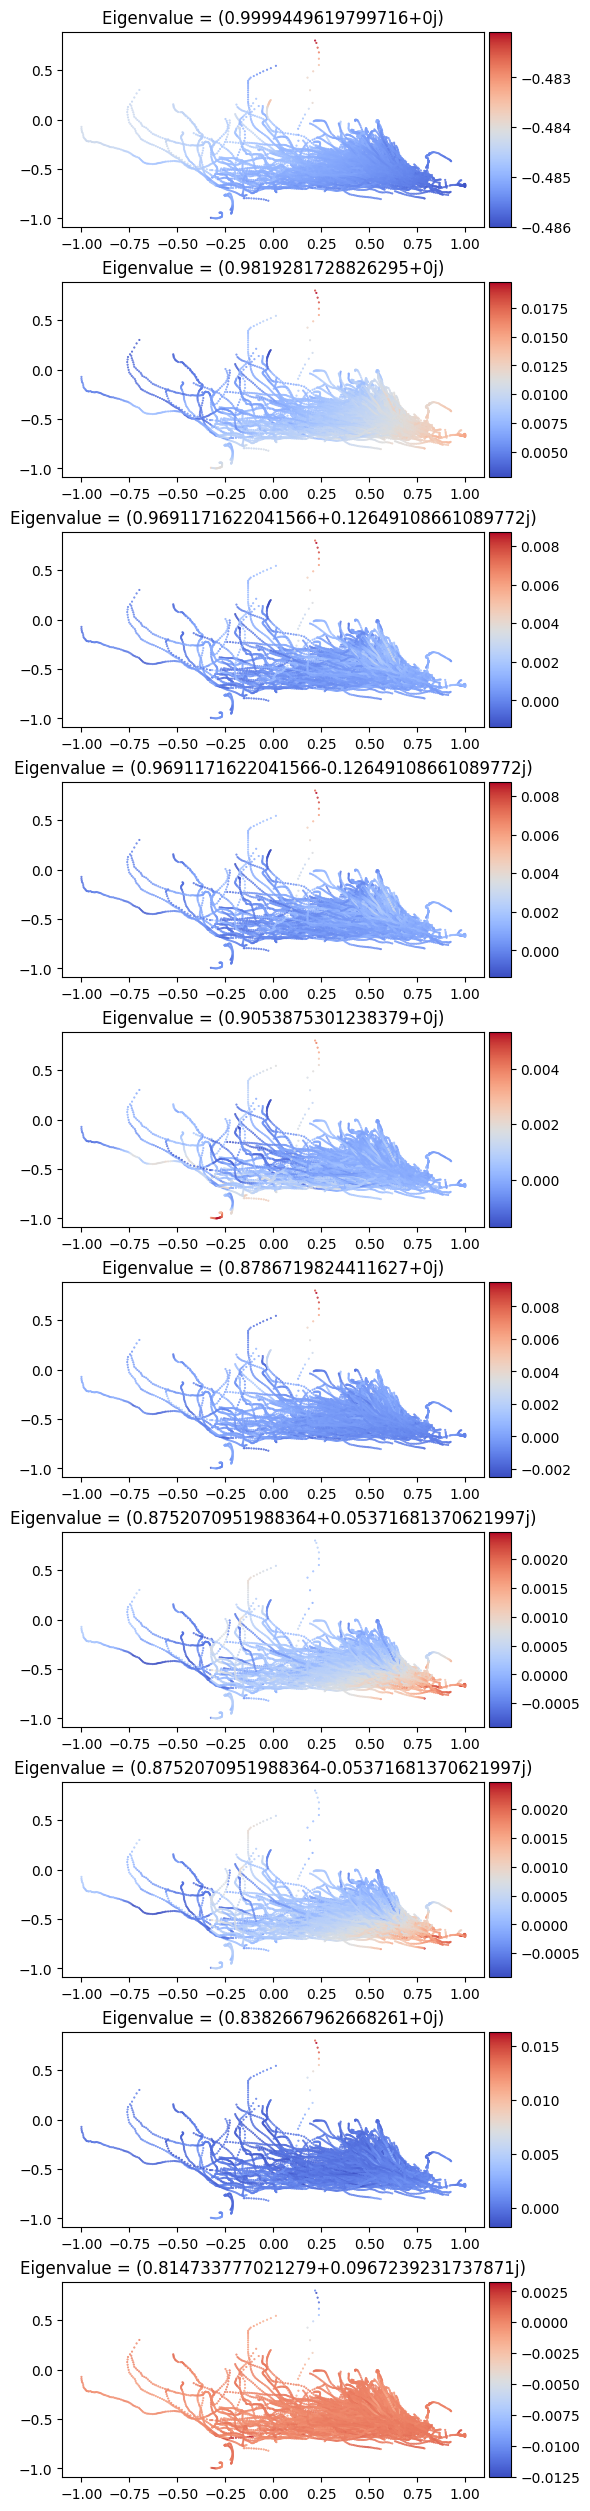

In [18]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(len(evec_idx), 1, constrained_layout=True)
fig.set_size_inches(5, 25)

idx = -1
cmap = plt.cm.coolwarm

for i, e_idx in enumerate(evec_idx):
    im = ax[i].scatter(test_dataset.data[:idx, 0, 0], test_dataset.data[:idx, 0, 1], marker=".", cmap=cmap, c = evec_right_k[:idx, e_idx], s = 1)
    divider = make_axes_locatable(ax[i])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    ax[i].set_title(f"Eigenvalue = {evals_k[e_idx]}")
